# 0. 라이브러리 설치

In [ ]:
!pip install pyod

# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

# 2. 모델링 데이터셋 생성

In [2]:
# 정상 데이터 생성
X_normal, y_normal = make_blobs(n_samples=1000, centers=1, n_features=5, cluster_std=1, random_state=0, center_box=(5,9))
df_normal = pd.DataFrame(X_normal, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_normal['anomaly_indicator']=0

In [3]:
# 이상 데이터 생성
X_abnormal, y_abnormal = make_blobs(n_samples=100, centers=5, n_features=5, cluster_std=10, random_state=0, center_box=(10,12))
df_abnormal = pd.DataFrame(X_abnormal, columns=['x1', 'x2', 'x3', 'x4', 'x5'])
df_abnormal['anomaly_indicator']=1

In [4]:
# 이상 데이터, 정상데이터 combine
df = pd.concat([df_normal, df_abnormal])
df

,x1,x2,x3,x4,x5,anomaly_indicator
0,6.494584,7.271328,7.349897,7.716592,5.643402,0
1,7.413977,8.425805,6.074440,6.837860,8.114223,0
2,8.637788,9.191025,5.564677,8.259005,7.899386,0
3,6.531363,8.531591,7.729810,7.424570,5.819417,0
4,7.170454,8.475608,8.507813,8.059357,6.009195,0
...,...,...,...,...,...,...
95,3.489619,20.531081,14.790570,11.509716,0.935149,1
96,3.109579,11.702274,-1.127039,5.316283,-1.035027,1
97,4.978399,10.471301,0.840310,11.031721,13.566606,1
98,-6.159087,13.036964,2.615674,9.025557,15.731574,1


<AxesSubplot:xlabel='x1', ylabel='x2'>

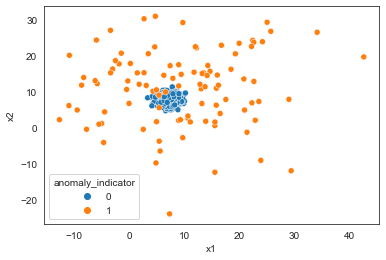

In [5]:
# 데이터 시각화 
plt.figure(figsize=(6, 4))
sns.scatterplot(df['x1'], df['x2'], hue=df['anomaly_indicator'])

# 3. 탐색적 데이터 분석

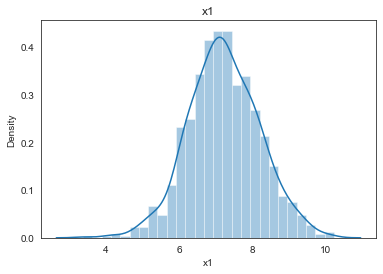

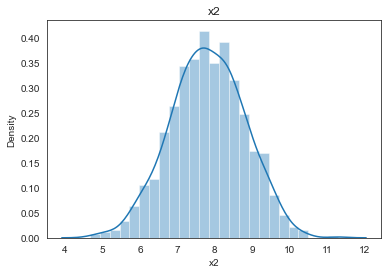

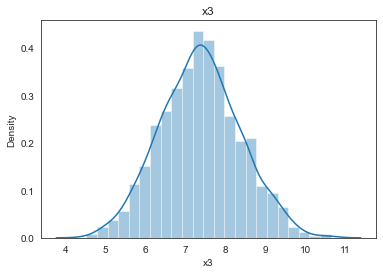

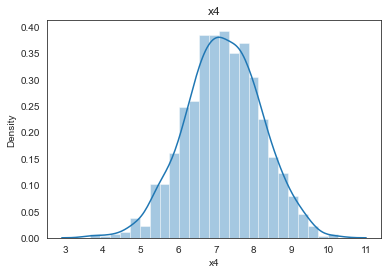

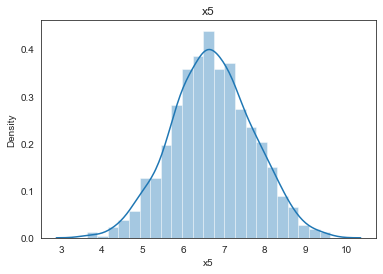

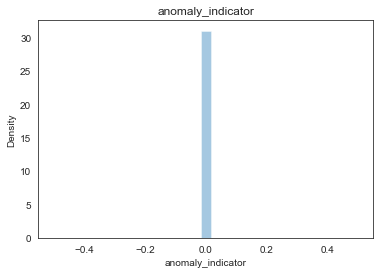

In [6]:
# 정상 데이터의 변수별 분포 확인

for col in df.columns:
    sns.distplot(df_normal.loc[df_normal[col].notnull(), col])
    plt.title(col)
    plt.show()

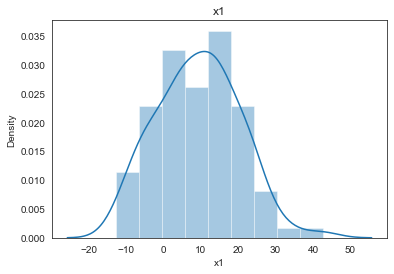

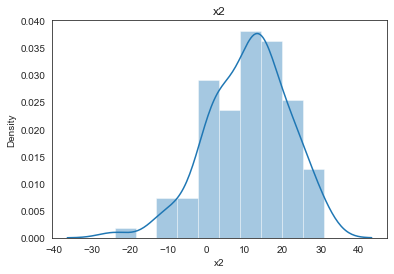

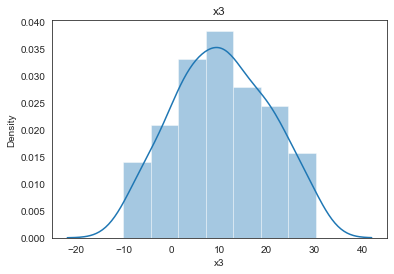

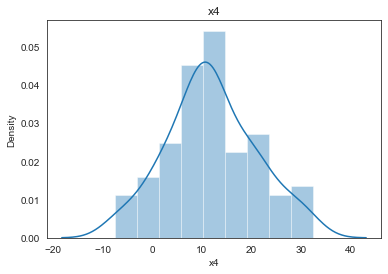

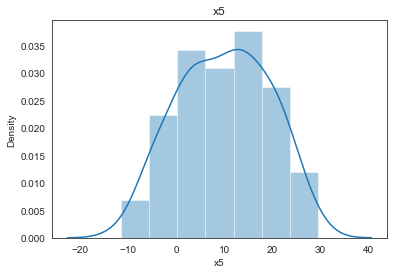

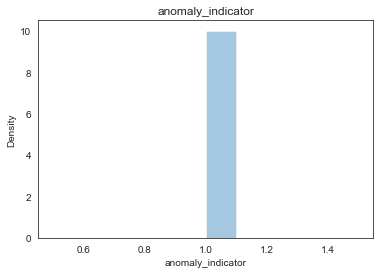

In [7]:
# 이상 데이터의 변수별 분포 확인

for col in df.columns:
    sns.distplot(df_abnormal.loc[df_abnormal[col].notnull(), col])
    plt.title(col)
    plt.show()

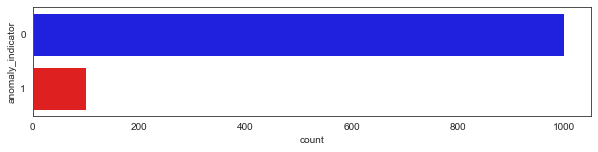

In [8]:
# 정상 데이터와 이상 데이터 클래수 비교
plt.figure(figsize=(10,2))
fig = sns.countplot(y=df['anomaly_indicator'], data=df, palette=["blue", "red"])
plt.show()

In [9]:
# 정상 데이터의 100개 랜덤 샘플링
test_normal_df = df_normal.sample(n = 100, random_state = 0)
test_normal_df

,x1,x2,x3,x4,x5,anomaly_indicator
993,7.080202,8.109752,7.191270,7.399265,6.039535,0
859,6.296319,9.675581,8.547711,7.743998,7.544982,0
298,6.118572,7.756738,6.592197,8.234647,6.047185,0
553,7.799414,8.332906,8.230971,8.087052,6.108796,0
672,7.556783,5.935538,5.847330,8.580580,9.418307,0
...,...,...,...,...,...,...
485,5.688678,7.393406,7.977216,7.958200,6.683645,0
568,6.862197,7.908122,8.873794,8.714562,7.261059,0
108,6.616562,7.132059,8.599875,6.649408,5.283798,0
367,7.823459,8.906383,7.576134,7.776221,7.455402,0


In [10]:
# 정상 데이터 100개 + 이상 데이터 100개 concat 하여 test 데이터셋 생성
test_df = pd.concat([df_abnormal, test_normal_df])

In [11]:
# test 데이터 셋 => X_test, y_test 분할
X_test = test_df[test_df.columns.difference(['anomaly_indicator'])]
y_test = test_df["anomaly_indicator"]

print('X_test:', X_test.shape, 'y_test:', y_test.shape)

X_test: (200, 5) y_test: (200,)


In [12]:
# 나머지 900개 정상 데이터로 train 데이터셋 생성
train_df = df_normal.drop(test_normal_df.index)

# train 데이터 셋 => X_train, y_train 분할
X_train = train_df[train_df.columns.difference(['anomaly_indicator'])]
y_train = train_df["anomaly_indicator"]

print('X_train:', X_train.shape, 'y_train:', y_train.shape)

X_train: (900, 5) y_train: (900,)


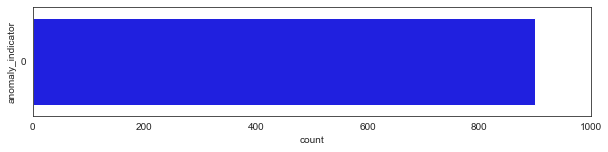

In [13]:
# train 데이터셋은 정상 데이터로만 구성
plt.figure(figsize=(10,2))
fig = sns.countplot(y=train_df['anomaly_indicator'], data=train_df, palette=["blue"])
plt.xlim(0, 1000)
plt.show()

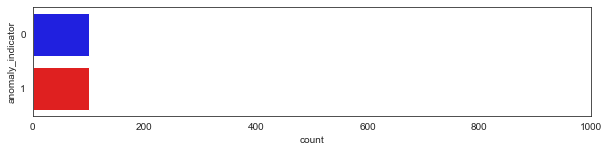

In [14]:
# test dataset은 정상과 이상 일대일 비율로 구성
plt.figure(figsize=(10,2))
fig = sns.countplot(y=test_df['anomaly_indicator'], data=test_df, palette=["blue", "red"])
plt.xlim(0, 1000)
plt.show()

# 4. 모델 구축

## 4-1. Isolation Forest

In [15]:
# Isolation Forest 모델 구축
IForest = IForest()
IForest.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [16]:
# train data에 대한 예측 값(정상=0, 이상=1)
IForest_train_pred = IForest.predict(X_train) 
IForest_train_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,

In [17]:
# test data에 대한 예측 값(정상=1, 이상=-1)
IForest_test_pred = IForest.predict(X_test) 
IForest_test_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0])

accuracy:  0.945
recall:  1.0
precision:  0.901
f1-score:  0.948


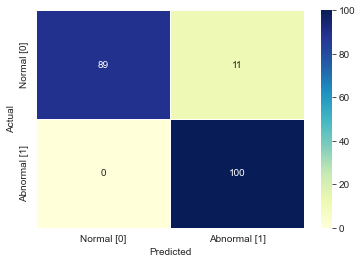

In [18]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, IForest_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, IForest_test_pred))
print("recall: ", round(recall_score(y_test, IForest_test_pred),3))
print("precision: ", round(precision_score(y_test, IForest_test_pred),3))
print("f1-score: ", round(f1_score(y_test, IForest_test_pred),3))

## 4-2. Local Outlier Factor

In [19]:
# LOF 모델 구축
LOF = LocalOutlierFactor(contamination=0.01,novelty=True)
LOF.fit(X_train)

LocalOutlierFactor(contamination=0.01, novelty=True)

In [20]:
# train data에 대한 예측 값(정상=1, 이상=-1)
LOF_train_pred = LOF.predict(X_train) 
LOF_train_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [21]:
# test data에 대한 예측 값(정상=1, 이상=-1)
LOF_test_pred = LOF.predict(X_test) 

LOF_test_pred = pd.DataFrame(LOF_test_pred)
LOF_test_pred = LOF_test_pred.replace({-1: 1, 1: 0})
LOF_test_pred

,0
0,1
1,1
2,1
3,1
4,1
...,...
195,0
196,0
197,0
198,0


accuracy:  0.98
recall:  1.0
precision:  0.962
f1-score:  0.98


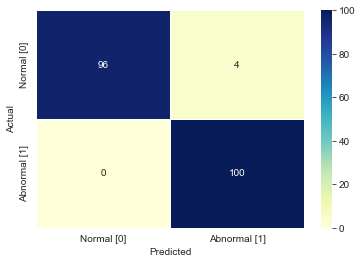

In [22]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, LOF_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, LOF_test_pred))
print("recall: ", round(recall_score(y_test, LOF_test_pred),3))
print("precision: ", round(precision_score(y_test, LOF_test_pred),3))
print("f1-score: ", round(f1_score(y_test, LOF_test_pred),3))

## 4-3. Pricipal Component Analysis

In [23]:
PCA = PCA()
PCA.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=None, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [24]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_train_pred = PCA.predict(X_train) 
PCA_train_pred

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,

In [25]:
# train data에 대한 예측 값(정상=0, 이상=1)
PCA_test_pred = PCA.predict(X_test) 
PCA_test_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0])

accuracy:  0.945
recall:  1.0
precision:  0.901
f1-score:  0.948


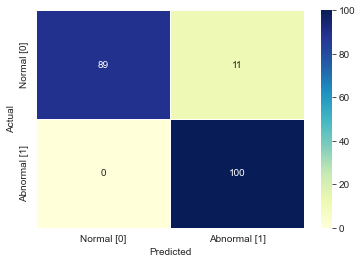

In [26]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, PCA_test_pred)

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, PCA_test_pred))
print("recall: ", round(recall_score(y_test, PCA_test_pred),3))
print("precision: ", round(precision_score(y_test, PCA_test_pred),3))
print("f1-score: ", round(f1_score(y_test, PCA_test_pred),3))

## 4-4. Auto-Encoder

In [27]:
input_dim = X_train.shape[1]

AE = tf.keras.models.Sequential([
    
    # encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

AE.compile(optimizer="adam", loss="mse")
AE.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 25        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = AE.fit(
    X_train,
    X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.3
)

Epoch 1/100
20/20 [==============================] - 3s 157ms/step - loss: 37.4048 - val_loss: 33.5473
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 32.3818 - val_loss: 28.2423
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 26.7171 - val_loss: 22.4972
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 20.9788 - val_loss: 16.2632
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 14.7745 - val_loss: 11.1100
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 9.9295 - val_loss: 7.3866
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 6.6803 - val_loss: 4.8891
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 4.2375 - val_loss: 3.3128
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 3.0839 - val_loss: 2.3411
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 2.1777 - val_loss: 1.76

Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7838 - val_loss: 0.7674
Epoch 84/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7936 - val_loss: 0.7677
Epoch 85/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7949 - val_loss: 0.7650
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7706 - val_loss: 0.7538
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7861 - val_loss: 0.7488
Epoch 88/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7382 - val_loss: 0.7243
Epoch 89/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7528 - val_loss: 0.7122
Epoch 90/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7530 - val_loss: 0.6999
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.7394 - val_loss: 0.6927
Epoch 92/100
20/20 [==============================] - 0s 3ms/step - loss: 0.7193 - val_loss: 0.6861


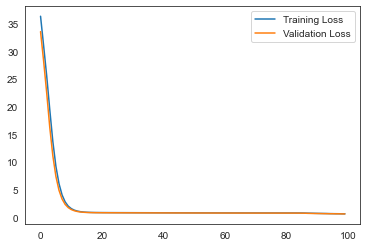

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [30]:
# train data에 대한 예측 값
AE_train_pred = AE.predict(X_train)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의 -> Novelty Score
train_mse = np.mean(np.power(X_train - AE_train_pred, 2), axis=1)
train_mse = pd.DataFrame({'Reconstruction_error': train_mse})
train_mse

,Reconstruction_error
0,0.369063
2,0.582087
3,0.440602
4,0.445475
5,0.562865
...,...
994,0.984588
995,0.259304
997,2.127688
998,0.556417


In [31]:
# train 데이터에 대한 novelty score 기준 상위 10% 의 값을 임계치로 설정
AE_thresh = np.percentile(sorted(train_mse['Reconstruction_error']), 90)
AE_thresh

1.2651010402791416

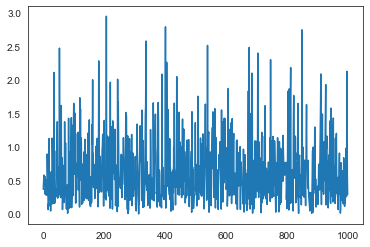

In [32]:
plt.plot(train_mse)

In [33]:
# test data에 대한 예측 값
AE_test_pred = AE.predict(X_test)

# 실제 값과 예측 값 사이의 차이인 MSE값을 reconstruction error로 정의
test_mse = np.mean(np.power(X_test - AE_test_pred, 2), axis=1)
test_mse

0       89.983265
1      215.190291
2      291.530636
3       18.875461
4      138.702575
          ...    
485      0.491541
568      0.347824
108      0.460332
367      0.080497
644      0.550625
Length: 200, dtype: float64

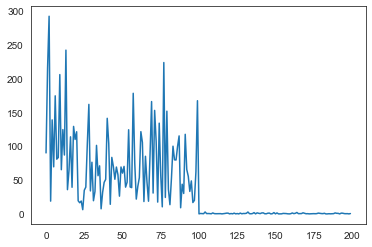

In [34]:
plt.plot(test_mse.values)

In [35]:
# classifier
# AE_thresh 기준, test_mse 값이 더 크면 이상(1), 작으면 정상(0)으로 분류
AE_test_df = []

def novelty_classifier(novelty_score):
    for i in range(len(novelty_score)):
        if novelty_score[i] > AE_thresh:
            AE_test_df.append(1)
        else:
            AE_test_df.append(0)

In [36]:
novelty_classifier(test_mse.values)

accuracy:  0.935
recall:  1.0
precision:  0.885
f1-score:  0.939


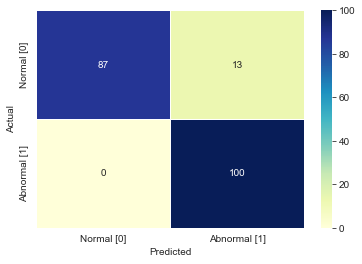

In [37]:
# Confusion matrix 출력 및 모델 성능 평가
con_mat = confusion_matrix(y_test, AE_test_df) #confusion_matrix 함수 실행

sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("accuracy: ", accuracy_score(y_test, AE_test_df))
print("recall: ", round(recall_score(y_test, AE_test_df),3))
print("precision: ", round(precision_score(y_test, AE_test_df),3))
print("f1-score: ", round(f1_score(y_test, AE_test_df),3))